In [1]:
#!pip3 install neat-python

# from keras.datasets import fashion_mnist
import tensorflow as tf
import numpy as np
import ssl
import neat
from skimage.transform import rescale
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import math
import pickle
import csv
import cv2
fashion_mnist = tf.keras.datasets.fashion_mnist



## Global Parameters

In [2]:
# Dataset parameters
DATASET = "Fashion-MNIST"
STANDARD_IMAGE_SIZE = 28
DESIRED_IMAGE_SIZE = (16,16)
N_CLASSES_TO_USE = 10

# How many samples to test:
N_SAMPLES_TO_TEST = 200

# Simulation Parameters
NR_GENERATIONS =1000
CONFIG_FILE = 'NEAT-configs/mnist-wann'

## Load Fashion-MNIST

In [3]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

## Preprocess Fashion-MNIST

In [4]:
def preprocess(samples, size, n_samples, unskew=True):
    # Create list of processed images
    processed  = np.empty((n_samples,size[0],size[1]))

    # Unskew and resize
    if unskew == True:    
        for i in range(n_samples):
            processed[i,:,:] = deskew(cv2.resize(samples[i,:,:],size),size)
    return processed

def deskew(image, image_shape, negated=True):
    """ source: https://github.com/vsvinayak/mnist-helper """
  
    # negate the image
    if not negated:
        image = 255-image
    
    # calculate the moments of the image
    m = cv2.moments(image)
    if abs(m['mu02']) < 1e-2:
        return image.copy()
    
    # caclulating the skew
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*image_shape[0]*skew], [0,1,0]])
    img = cv2.warpAffine(image, M, image_shape, flags=cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR)  
    return img

n_samples_train = X_train.shape[0]
n_samples_test = X_test.shape[0]

# Rescale and preprocess training and testing data
X_train_processed = preprocess(X_train/255, DESIRED_IMAGE_SIZE, n_samples_train)
X_test_processed = preprocess(X_test/255, DESIRED_IMAGE_SIZE, n_samples_test)
    
    

##### WRAPPING UP #####
    
# Replace and reshape X_train and X_test, for convenience
X_train = X_train_processed.reshape(n_samples_train, np.prod(DESIRED_IMAGE_SIZE))
X_test = X_test_processed.reshape(n_samples_test, np.prod(DESIRED_IMAGE_SIZE))

### Visualize

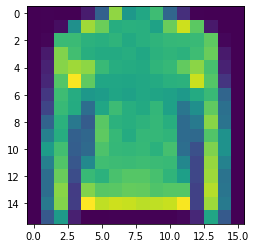

In [5]:
plt.imshow(X_train_processed[37])

# NEAT

## Basic Run Function

In [6]:
def exp(x):
    return np.exp(np.clip(x, -float('inf'), 709.))

# def sigmoid(output):
#     output = [min(709., x) for x in output]
#     output = [max(-709., x) for x in output]
#     return [1 /(1 + exp(-x)) for x in output]

def softmax(output):
    e = exp(output)
    return e / e.sum()

In [7]:
def step(x):
    return 1.0*(x>0.0)

def wann_cos(x):
    x = max(-60.0, min(60.0, 5.0 * x))
    return math.cos(math.pi*x)

def wann_sin(x):
    x = max(-60.0, min(60.0, 5.0 * x))
    return math.sin(math.pi * x)
        
def wann_sigmoid(x):
    x = max(-60.0, min(60.0, 5.0 * x))
    return (math.tanh(x/2.0) + 1.0)/2.0

def wann_inverse(x):
    return -x

def wann_gauss(x):
    x = max(-3.4, min(3.4, x))
    return exp(- (x*x) / 2.0)

def run(config_file):
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

    config.genome_config.add_activation('step', step)
    config.genome_config.add_activation('wcos', wann_cos)
    config.genome_config.add_activation('wsin', wann_sin)
    config.genome_config.add_activation('wsig', wann_sigmoid)
    config.genome_config.add_activation('winv', wann_inverse)
    config.genome_config.add_activation('wgauss', wann_gauss)
    
    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)
    
    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    
    p.add_reporter(stats)
    #p.add_reporter(neat.Checkpointer(50, filename_prefix='NEAT-checkpoints/neat-checkpoint-10-classes-fashion-'))
    
    
    # Run for up to NR_GENERATIONS generations.
    winner = p.run(eval_genomes, NR_GENERATIONS)
    stats.save_genome_fitness(filename="NEAT-results/fashion_fitness_history.csv")
    stats.save_species_count(filename="NEAT-results/fashion_species_count.csv")
    with open('NEAT-results/best_genomes_fashion', 'wb') as f:
        best_genomes = stats.best_genomes(10)
        pickle.dump(best_genomes,f)
    
    
    # Display the winning genome.
    print('\nBest genome:\n{!s}'.format(winner))


## Basic Evaluation Function

In [8]:
def eval_genomes(genomes, config):
    
    def _cross_entropy(pred, label):
        return -np.log(pred[label])
    
    sample_indices = []
    n_samples_per_class = int(N_SAMPLES_TO_TEST/N_CLASSES_TO_USE)
    for c in range(N_CLASSES_TO_USE):
        c_indices = np.where(Y_train == c)[0]
        assert len(c_indices) >= n_samples_per_class, \
            f"Class {c} has too few elements to reach the desired number of evaluation samples"
        sample_indices.extend(np.random.permutation(c_indices)[:n_samples_per_class])
    
    # Compute cross-entropy loss for each of the samples
    losses = []
    for i in sample_indices:
        X_sample, Y_sample = X_train[i], Y_train[i]
        
    nr_nodes = 0
    nr_connections = 0
    for genome_id, genome in genomes:
        nr_nodes +=len(genome.nodes)
        nr_connections +=len(genome.connections)
        
        
        ce = []
        
        genome.fitness = 0.
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        nr_correct = 0.
        for i in sample_indices:
            train, label = X_train[i], Y_train[i]
            output = softmax(net.activate(train))

            ce.append(-_cross_entropy(output, label))

        genome.fitness = np.average(ce) 
    
    avg_nodes = nr_nodes / float(len(genomes))
    avg_connections = nr_connections / float(len(genomes))
    with open("NEAT-results/sizes_fashion_mnist.csv",'a', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow([avg_nodes, avg_connections])           
    

In [9]:
run(CONFIG_FILE)


 ****** Running generation 0 ****** 

Population's average fitness: -4.47740 stdev: 0.83957
Best fitness: -2.56497 - size: (10, 128) - species 1 - id 137
Average adjusted fitness: 0.551
Mean genetic distance 2.302, standard deviation 0.291
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   250     -2.6    0.551     0
Total extinctions: 0
Generation time: 8.195 sec

 ****** Running generation 1 ****** 

Population's average fitness: -3.86575 stdev: 0.68400
Best fitness: -2.48308 - size: (10, 128) - species 1 - id 372
Average adjusted fitness: 0.646
Mean genetic distance 2.222, standard deviation 0.456
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   250     -2.5    0.646     0
Total extinctions: 0
Generation time: 8.154 sec (8.174 average)

 ****** Running generation 2 ****** 

Population's average fitness: -3.84

Population's average fitness: -3.55492 stdev: 0.76556
Best fitness: -2.30104 - size: (11, 129) - species 1 - id 4171
Average adjusted fitness: 0.631
Mean genetic distance 1.902, standard deviation 0.839
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   18   250     -2.3    0.631     1
Total extinctions: 0
Generation time: 8.946 sec (8.955 average)

 ****** Running generation 19 ****** 

Population's average fitness: -3.56053 stdev: 0.70745
Best fitness: -2.30228 - size: (11, 123) - species 1 - id 4924
Average adjusted fitness: 0.599
Mean genetic distance 1.957, standard deviation 0.753
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   19   250     -2.3    0.599     2
Total extinctions: 0
Generation time: 8.878 sec (8.957 average)

 ****** Running generation 20 ****** 

Population's average fitness: -3.56067 stdev: 0.71806


Population's average fitness: -3.45203 stdev: 0.64410
Best fitness: -2.28915 - size: (11, 129) - species 1 - id 4171
Average adjusted fitness: 0.594
Mean genetic distance 0.669, standard deviation 0.085
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   36   250     -2.3    0.594     4
Total extinctions: 0
Generation time: 9.240 sec (9.190 average)

 ****** Running generation 37 ****** 

Population's average fitness: -3.56458 stdev: 0.73203
Best fitness: -2.30592 - size: (11, 129) - species 1 - id 4171
Average adjusted fitness: 0.560
Mean genetic distance 0.649, standard deviation 0.084
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   37   250     -2.3    0.560     5
Total extinctions: 0
Generation time: 9.099 sec (9.217 average)

 ****** Running generation 38 ****** 

Population's average fitness: -3.41403 stdev: 0.72113


Population's average fitness: -3.48840 stdev: 0.69229
Best fitness: -2.27703 - size: (11, 123) - species 1 - id 11942
Average adjusted fitness: 0.654
Mean genetic distance 0.674, standard deviation 0.097
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   54   250     -2.3    0.654     1
Total extinctions: 0
Generation time: 8.915 sec (9.590 average)

 ****** Running generation 55 ****** 

Population's average fitness: -3.54698 stdev: 0.77182
Best fitness: -2.26382 - size: (11, 123) - species 1 - id 11942
Average adjusted fitness: 0.661
Mean genetic distance 0.661, standard deviation 0.114
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   55   250     -2.3    0.661     2
Total extinctions: 0
Generation time: 9.154 sec (9.633 average)

 ****** Running generation 56 ****** 

Population's average fitness: -3.55827 stdev: 0.7722

Population's average fitness: -3.45227 stdev: 0.78544
Best fitness: -2.27797 - size: (13, 124) - species 1 - id 16027
Average adjusted fitness: 0.704
Mean genetic distance 0.633, standard deviation 0.132
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   72   250     -2.3    0.704     3
Total extinctions: 0
Generation time: 8.948 sec (9.241 average)

 ****** Running generation 73 ****** 

Population's average fitness: -3.54668 stdev: 0.77253
Best fitness: -2.26172 - size: (13, 124) - species 1 - id 16027
Average adjusted fitness: 0.673
Mean genetic distance 0.640, standard deviation 0.146
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   73   250     -2.3    0.673     4
Total extinctions: 0
Generation time: 8.810 sec (9.162 average)

 ****** Running generation 74 ****** 

Population's average fitness: -3.55143 stdev: 0.8351

Population's average fitness: -3.30730 stdev: 0.70251
Best fitness: -2.26525 - size: (13, 124) - species 1 - id 16027
Average adjusted fitness: 0.681
Mean genetic distance 0.767, standard deviation 0.129
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   90   250     -2.3    0.681    12
Total extinctions: 0
Generation time: 9.519 sec (9.172 average)

 ****** Running generation 91 ****** 

Population's average fitness: -3.36212 stdev: 0.76838
Best fitness: -2.26278 - size: (13, 124) - species 1 - id 16027
Average adjusted fitness: 0.696
Mean genetic distance 0.749, standard deviation 0.127
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   91   250     -2.3    0.696    13
Total extinctions: 0
Generation time: 9.595 sec (9.195 average)

 ****** Running generation 92 ****** 

Population's average fitness: -3.25629 stdev: 0.6922

Mean genetic distance 0.816, standard deviation 0.099
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  107   250     -2.3    0.651     4
Total extinctions: 0
Generation time: 9.970 sec (9.235 average)

 ****** Running generation 108 ****** 

Population's average fitness: -3.30702 stdev: 0.70194
Best fitness: -2.23271 - size: (14, 123) - species 1 - id 26903
Average adjusted fitness: 0.668
Mean genetic distance 0.792, standard deviation 0.107
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  108   250     -2.2    0.668     5
Total extinctions: 0
Generation time: 9.361 sec (9.212 average)

 ****** Running generation 109 ****** 

Population's average fitness: -3.28909 stdev: 0.66791
Best fitness: -2.25042 - size: (14, 123) - species 1 - id 26903
Average adjusted fitness: 0.628
Mean genetic distance 0.754, standard deviation 0.

Population's average fitness: -3.07405 stdev: 0.57479
Best fitness: -2.24049 - size: (13, 124) - species 1 - id 23682
Average adjusted fitness: 0.709
Mean genetic distance 1.013, standard deviation 0.222
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  125   250     -2.2    0.709    10
Total extinctions: 0
Generation time: 8.406 sec (8.928 average)

 ****** Running generation 126 ****** 

Population's average fitness: -3.16124 stdev: 0.71132
Best fitness: -2.23031 - size: (14, 123) - species 1 - id 26903
Average adjusted fitness: 0.731
Mean genetic distance 1.008, standard deviation 0.249
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  126   250     -2.2    0.731    11
Total extinctions: 0
Generation time: 8.482 sec (8.838 average)

 ****** Running generation 127 ****** 

Population's average fitness: -3.22947 stdev: 0.71

Mean genetic distance 1.074, standard deviation 0.229
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  142   250     -2.2    0.676    27
Total extinctions: 0
Generation time: 7.828 sec (8.090 average)

 ****** Running generation 143 ****** 

Population's average fitness: -3.02856 stdev: 0.58986
Best fitness: -2.21463 - size: (14, 123) - species 1 - id 26903
Average adjusted fitness: 0.707
Mean genetic distance 1.070, standard deviation 0.224
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  143   250     -2.2    0.707    28
Total extinctions: 0
Generation time: 7.624 sec (8.027 average)

 ****** Running generation 144 ****** 

Population's average fitness: -2.96241 stdev: 0.57959
Best fitness: -2.20370 - size: (14, 123) - species 1 - id 26903
Average adjusted fitness: 0.727
Mean genetic distance 1.034, standard deviation 0.

Population's average fitness: -2.92673 stdev: 0.55772
Best fitness: -2.22048 - size: (14, 114) - species 1 - id 38147
Average adjusted fitness: 0.714
Mean genetic distance 1.206, standard deviation 0.308
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  160   250     -2.2    0.714    45
Total extinctions: 0
Generation time: 7.804 sec (7.539 average)

 ****** Running generation 161 ****** 

Population's average fitness: -2.87844 stdev: 0.52456
Best fitness: -2.21257 - size: (14, 114) - species 1 - id 38147
Average adjusted fitness: 0.759
Mean genetic distance 1.250, standard deviation 0.286
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  161   250     -2.2    0.759    46
Total extinctions: 0
Generation time: 8.012 sec (7.566 average)

 ****** Running generation 162 ****** 

Population's average fitness: -2.80891 stdev: 0.50

Population's average fitness: -2.79654 stdev: 0.51562
Best fitness: -2.21401 - size: (14, 114) - species 1 - id 38147
Average adjusted fitness: 0.735
Mean genetic distance 1.291, standard deviation 0.267
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  178   250     -2.2    0.735    63
Total extinctions: 0
Generation time: 8.439 sec (8.367 average)

 ****** Running generation 179 ****** 

Population's average fitness: -2.74210 stdev: 0.48790
Best fitness: -2.22536 - size: (14, 114) - species 1 - id 38147
Average adjusted fitness: 0.799
Mean genetic distance 1.270, standard deviation 0.301
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  179   250     -2.2    0.799    64
Total extinctions: 0
Generation time: 8.445 sec (8.398 average)

 ****** Running generation 180 ****** 

Population's average fitness: -2.79137 stdev: 0.45

Mean genetic distance 1.205, standard deviation 0.314
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  195   250     -2.2    0.838     1
Total extinctions: 0
Generation time: 8.548 sec (8.404 average)

 ****** Running generation 196 ****** 

Population's average fitness: -2.60590 stdev: 0.40151
Best fitness: -2.20394 - size: (29, 129) - species 1 - id 47478
Average adjusted fitness: 0.770
Mean genetic distance 1.142, standard deviation 0.374
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  196   250     -2.2    0.770     2
Total extinctions: 0
Generation time: 8.104 sec (8.323 average)

 ****** Running generation 197 ****** 

Population's average fitness: -2.65003 stdev: 0.45056
Best fitness: -2.18437 - size: (29, 129) - species 1 - id 47478
Average adjusted fitness: 0.777
Mean genetic distance 1.165, standard deviation 0.

Population's average fitness: -2.53897 stdev: 0.40722
Best fitness: -2.19339 - size: (29, 124) - species 1 - id 52277
Average adjusted fitness: 0.838
Mean genetic distance 0.862, standard deviation 0.259
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  213   250     -2.2    0.838     7
Total extinctions: 0
Generation time: 8.030 sec (8.217 average)

 ****** Running generation 214 ****** 

Population's average fitness: -2.48708 stdev: 0.43630
Best fitness: -2.17004 - size: (29, 129) - species 1 - id 47478
Average adjusted fitness: 0.930
Mean genetic distance 0.893, standard deviation 0.235
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  214   250     -2.2    0.930     8
Total extinctions: 0
Generation time: 8.081 sec (8.248 average)

 ****** Running generation 215 ****** 

Population's average fitness: -2.47413 stdev: 0.35

Mean genetic distance 1.154, standard deviation 0.312
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  230   250     -2.2    0.870     8
Total extinctions: 0
Generation time: 7.720 sec (7.746 average)

 ****** Running generation 231 ****** 

Population's average fitness: -2.46756 stdev: 0.36713
Best fitness: -2.16196 - size: (29, 124) - species 1 - id 52277
Average adjusted fitness: 0.852
Mean genetic distance 1.101, standard deviation 0.298
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  231   250     -2.2    0.852     9
Total extinctions: 0
Generation time: 7.573 sec (7.703 average)

 ****** Running generation 232 ****** 

Population's average fitness: -2.47059 stdev: 0.33650
Best fitness: -2.18900 - size: (29, 124) - species 1 - id 52277
Average adjusted fitness: 0.868
Mean genetic distance 1.036, standard deviation 0.

Population's average fitness: -2.41019 stdev: 0.33974
Best fitness: -2.18308 - size: (22, 96) - species 1 - id 59980
Average adjusted fitness: 0.929
Mean genetic distance 0.825, standard deviation 0.236
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  248   250     -2.2    0.929    26
Total extinctions: 0
Generation time: 7.302 sec (7.526 average)

 ****** Running generation 249 ****** 

Population's average fitness: -2.38857 stdev: 0.24317
Best fitness: -2.17383 - size: (22, 96) - species 1 - id 59980
Average adjusted fitness: 0.884
Mean genetic distance 0.890, standard deviation 0.249
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  249   250     -2.2    0.884    27
Total extinctions: 0
Generation time: 7.011 sec (7.462 average)

 ****** Running generation 250 ****** 

Population's average fitness: -2.42201 stdev: 0.3907

Population's average fitness: -2.42501 stdev: 0.26203
Best fitness: -2.14209 - size: (22, 94) - species 1 - id 65115
Average adjusted fitness: 0.840
Mean genetic distance 1.063, standard deviation 0.358
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  266   250     -2.1    0.840    14
Total extinctions: 0
Generation time: 7.362 sec (7.116 average)

 ****** Running generation 267 ****** 

Population's average fitness: -2.44616 stdev: 0.26759
Best fitness: -2.15127 - size: (20, 90) - species 1 - id 65926
Average adjusted fitness: 0.832
Mean genetic distance 1.051, standard deviation 0.344
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  267   250     -2.2    0.832    15
Total extinctions: 0
Generation time: 7.334 sec (7.123 average)

 ****** Running generation 268 ****** 

Population's average fitness: -2.42953 stdev: 0.3226

Population's average fitness: -2.51991 stdev: 0.31190
Best fitness: -2.16028 - size: (21, 95) - species 1 - id 70200
Average adjusted fitness: 0.777
Mean genetic distance 0.753, standard deviation 0.093
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  284   250     -2.2    0.777     9
Total extinctions: 0
Generation time: 7.158 sec (7.382 average)

 ****** Running generation 285 ****** 

Population's average fitness: -2.50572 stdev: 0.32687
Best fitness: -2.14720 - size: (21, 100) - species 1 - id 70854
Average adjusted fitness: 0.786
Mean genetic distance 0.774, standard deviation 0.079
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  285   250     -2.1    0.786    10
Total extinctions: 0
Generation time: 7.237 sec (7.354 average)

 ****** Running generation 286 ****** 

Population's average fitness: -2.46358 stdev: 0.314

Population's average fitness: -2.50746 stdev: 0.36057
Best fitness: -2.10456 - size: (24, 99) - species 1 - id 74950
Average adjusted fitness: 0.784
Mean genetic distance 0.616, standard deviation 0.120
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  302   250     -2.1    0.784     3
Total extinctions: 0
Generation time: 7.617 sec (7.565 average)

 ****** Running generation 303 ****** 

Population's average fitness: -2.47882 stdev: 0.33723
Best fitness: -2.10460 - size: (22, 97) - species 1 - id 71403
Average adjusted fitness: 0.747
Mean genetic distance 0.599, standard deviation 0.124
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  303   250     -2.1    0.747     4
Total extinctions: 0
Generation time: 7.359 sec (7.542 average)

 ****** Running generation 304 ****** 

Population's average fitness: -2.49271 stdev: 0.3804

Population's average fitness: -2.49080 stdev: 0.34115
Best fitness: -2.09108 - size: (23, 94) - species 1 - id 79431
Average adjusted fitness: 0.763
Mean genetic distance 0.762, standard deviation 0.090
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  320   250     -2.1    0.763     3
Total extinctions: 0
Generation time: 7.796 sec (7.649 average)

 ****** Running generation 321 ****** 

Population's average fitness: -2.49945 stdev: 0.35208
Best fitness: -2.12092 - size: (23, 94) - species 1 - id 79431
Average adjusted fitness: 0.812
Mean genetic distance 0.760, standard deviation 0.084
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  321   250     -2.1    0.812     4
Total extinctions: 0
Generation time: 7.834 sec (7.687 average)

 ****** Running generation 322 ****** 

Population's average fitness: -2.42648 stdev: 0.3049

Population's average fitness: -2.43677 stdev: 0.30232
Best fitness: -2.05954 - size: (24, 93) - species 1 - id 83006
Average adjusted fitness: 0.797
Mean genetic distance 1.079, standard deviation 0.273
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  338   250     -2.1    0.797     7
Total extinctions: 0
Generation time: 7.924 sec (7.784 average)

 ****** Running generation 339 ****** 

Population's average fitness: -2.47470 stdev: 0.35042
Best fitness: -2.06714 - size: (24, 93) - species 1 - id 83006
Average adjusted fitness: 0.835
Mean genetic distance 1.111, standard deviation 0.275
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  339   250     -2.1    0.835     8
Total extinctions: 0
Generation time: 7.510 sec (7.745 average)

 ****** Running generation 340 ****** 

Population's average fitness: -2.45189 stdev: 0.3066

Population's average fitness: -2.48725 stdev: 0.29905
Best fitness: -2.05587 - size: (24, 93) - species 1 - id 83006
Average adjusted fitness: 0.726
Mean genetic distance 0.639, standard deviation 0.120
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  356   250     -2.1    0.726     9
Total extinctions: 0
Generation time: 7.658 sec (7.419 average)

 ****** Running generation 357 ****** 

Population's average fitness: -2.45374 stdev: 0.31653
Best fitness: -1.99335 - size: (24, 93) - species 1 - id 83006
Average adjusted fitness: 0.736
Mean genetic distance 0.608, standard deviation 0.131
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  357   250     -2.0    0.736     0
Total extinctions: 0
Generation time: 7.441 sec (7.438 average)

 ****** Running generation 358 ****** 

Population's average fitness: -2.53839 stdev: 0.3649

Population's average fitness: -2.46525 stdev: 0.33336
Best fitness: -2.06554 - size: (25, 94) - species 1 - id 88785
Average adjusted fitness: 0.767
Mean genetic distance 0.584, standard deviation 0.122
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  374   250     -2.1    0.767    17
Total extinctions: 0
Generation time: 7.377 sec (7.556 average)

 ****** Running generation 375 ****** 

Population's average fitness: -2.46684 stdev: 0.29682
Best fitness: -2.04796 - size: (25, 94) - species 1 - id 88785
Average adjusted fitness: 0.700
Mean genetic distance 0.624, standard deviation 0.133
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  375   250     -2.0    0.700    18
Total extinctions: 0
Generation time: 7.287 sec (7.525 average)

 ****** Running generation 376 ****** 

Population's average fitness: -2.45080 stdev: 0.3181

Mean genetic distance 0.599, standard deviation 0.146
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  391   250     -2.1    0.777    34
Total extinctions: 0
Generation time: 7.616 sec (7.455 average)

 ****** Running generation 392 ****** 

Population's average fitness: -2.48402 stdev: 0.33782
Best fitness: -2.07439 - size: (25, 94) - species 1 - id 88785
Average adjusted fitness: 0.778
Mean genetic distance 0.624, standard deviation 0.149
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  392   250     -2.1    0.778    35
Total extinctions: 0
Generation time: 7.585 sec (7.465 average)

 ****** Running generation 393 ****** 

Population's average fitness: -2.50731 stdev: 0.34722
Best fitness: -2.03974 - size: (24, 93) - species 1 - id 83006
Average adjusted fitness: 0.721
Mean genetic distance 0.604, standard deviation 0.15

Population's average fitness: -2.48820 stdev: 0.31931
Best fitness: -2.05531 - size: (24, 93) - species 1 - id 83006
Average adjusted fitness: 0.721
Mean genetic distance 0.659, standard deviation 0.150
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  409   250     -2.1    0.721    52
Total extinctions: 0
Generation time: 7.380 sec (7.651 average)

 ****** Running generation 410 ****** 

Population's average fitness: -2.48592 stdev: 0.30351
Best fitness: -2.05410 - size: (24, 93) - species 1 - id 83006
Average adjusted fitness: 0.753
Mean genetic distance 0.641, standard deviation 0.159
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  410   250     -2.1    0.753    53
Total extinctions: 0
Generation time: 7.534 sec (7.620 average)

 ****** Running generation 411 ****** 

Population's average fitness: -2.57801 stdev: 0.3922

Population's average fitness: -2.40130 stdev: 0.27488
Best fitness: -2.05594 - size: (24, 93) - species 1 - id 83006
Average adjusted fitness: 0.807
Mean genetic distance 0.839, standard deviation 0.297
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  427   250     -2.1    0.807    70
Total extinctions: 0
Generation time: 7.229 sec (7.034 average)

 ****** Running generation 428 ****** 

Population's average fitness: -2.41283 stdev: 0.28384
Best fitness: -2.06636 - size: (24, 93) - species 1 - id 83006
Average adjusted fitness: 0.815
Mean genetic distance 0.882, standard deviation 0.289
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  428   250     -2.1    0.815    71
Total extinctions: 0
Generation time: 7.152 sec (7.071 average)

 ****** Running generation 429 ****** 

Population's average fitness: -2.43065 stdev: 0.3351

Population's average fitness: -2.41237 stdev: 0.29385
Best fitness: -2.07452 - size: (24, 93) - species 1 - id 83006
Average adjusted fitness: 0.787
Mean genetic distance 1.028, standard deviation 0.418
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  445   250     -2.1    0.787    88
Total extinctions: 0
Generation time: 7.562 sec (7.711 average)

 ****** Running generation 446 ****** 

Population's average fitness: -2.40637 stdev: 0.33882
Best fitness: -2.06943 - size: (24, 93) - species 1 - id 83006
Average adjusted fitness: 0.896
Mean genetic distance 0.987, standard deviation 0.443
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  446   250     -2.1    0.896    89
Total extinctions: 0
Generation time: 7.569 sec (7.725 average)

 ****** Running generation 447 ****** 

Population's average fitness: -2.41120 stdev: 0.2806

Population's average fitness: -2.37432 stdev: 0.34350
Best fitness: -2.01702 - size: (24, 85) - species 1 - id 112336
Average adjusted fitness: 0.894
Mean genetic distance 1.225, standard deviation 0.450
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  463   250     -2.0    0.894   106
Total extinctions: 0
Generation time: 7.725 sec (7.794 average)

 ****** Running generation 464 ****** 

Population's average fitness: -2.40054 stdev: 0.36053
Best fitness: -2.06193 - size: (24, 86) - species 1 - id 114660
Average adjusted fitness: 0.887
Mean genetic distance 1.317, standard deviation 0.411
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  464   250     -2.1    0.887   107
Total extinctions: 0
Generation time: 8.091 sec (7.849 average)

 ****** Running generation 465 ****** 

Population's average fitness: -2.37654 stdev: 0.25

Mean genetic distance 1.401, standard deviation 0.408
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  480   250     -2.1    0.842   123
Total extinctions: 0
Generation time: 8.247 sec (8.324 average)

 ****** Running generation 481 ****** 

Population's average fitness: -2.39235 stdev: 0.29904
Best fitness: -2.07121 - size: (24, 86) - species 1 - id 114660
Average adjusted fitness: 0.816
Mean genetic distance 1.395, standard deviation 0.416
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  481   250     -2.1    0.816   124
Total extinctions: 0
Generation time: 7.888 sec (8.271 average)

 ****** Running generation 482 ****** 

Population's average fitness: -2.37456 stdev: 0.32038
Best fitness: -2.04004 - size: (24, 86) - species 1 - id 114660
Average adjusted fitness: 0.842
Mean genetic distance 1.256, standard deviation 0.

Population's average fitness: -2.39465 stdev: 0.34472
Best fitness: -2.05201 - size: (24, 85) - species 1 - id 112336
Average adjusted fitness: 0.872
Mean genetic distance 1.188, standard deviation 0.548
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  498   250     -2.1    0.872   141
Total extinctions: 0
Generation time: 8.290 sec (8.230 average)

 ****** Running generation 499 ****** 

Population's average fitness: -2.39789 stdev: 0.25996
Best fitness: -2.09441 - size: (24, 85) - species 1 - id 112336
Average adjusted fitness: 0.774
Mean genetic distance 1.316, standard deviation 0.502
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  499   250     -2.1    0.774   142
Total extinctions: 0
Generation time: 8.576 sec (8.225 average)

 ****** Running generation 500 ****** 

Population's average fitness: -2.35055 stdev: 0.23

Mean genetic distance 1.393, standard deviation 0.540
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  515   250     -2.0    0.801   158
Total extinctions: 0
Generation time: 8.386 sec (8.065 average)

 ****** Running generation 516 ****** 

Population's average fitness: -2.39109 stdev: 0.26717
Best fitness: -2.09959 - size: (26, 88) - species 1 - id 124580
Average adjusted fitness: 0.831
Mean genetic distance 1.272, standard deviation 0.592
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  516   250     -2.1    0.831   159
Total extinctions: 0
Generation time: 8.548 sec (8.084 average)

 ****** Running generation 517 ****** 

Population's average fitness: -2.36158 stdev: 0.31311
Best fitness: -2.06054 - size: (26, 89) - species 1 - id 128290
Average adjusted fitness: 0.911
Mean genetic distance 1.204, standard deviation 0.

Population's average fitness: -2.41062 stdev: 0.30399
Best fitness: -2.05743 - size: (26, 88) - species 1 - id 124580
Average adjusted fitness: 0.810
Mean genetic distance 1.311, standard deviation 0.610
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  533   250     -2.1    0.810   176
Total extinctions: 0
Generation time: 9.245 sec (8.813 average)

 ****** Running generation 534 ****** 

Population's average fitness: -2.38808 stdev: 0.25947
Best fitness: -2.09688 - size: (26, 89) - species 1 - id 128290
Average adjusted fitness: 0.845
Mean genetic distance 1.270, standard deviation 0.654
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  534   250     -2.1    0.845   177
Total extinctions: 0
Generation time: 8.505 sec (8.826 average)

 ****** Running generation 535 ****** 

Population's average fitness: -2.38466 stdev: 0.31

Mean genetic distance 1.559, standard deviation 0.592
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  550   250     -2.1    0.802   193
Total extinctions: 0
Generation time: 8.218 sec (8.487 average)

 ****** Running generation 551 ****** 

Population's average fitness: -2.37384 stdev: 0.29554
Best fitness: -2.05615 - size: (26, 91) - species 1 - id 136234
Average adjusted fitness: 0.840
Mean genetic distance 1.470, standard deviation 0.636
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  551   250     -2.1    0.840   194
Total extinctions: 0
Generation time: 8.123 sec (8.479 average)

 ****** Running generation 552 ****** 

Population's average fitness: -2.39962 stdev: 0.29092
Best fitness: -2.08914 - size: (26, 91) - species 1 - id 136234
Average adjusted fitness: 0.821
Mean genetic distance 1.594, standard deviation 0.

Population's average fitness: -2.39264 stdev: 0.31570
Best fitness: -2.04322 - size: (25, 88) - species 1 - id 138026
Average adjusted fitness: 0.799
Mean genetic distance 1.467, standard deviation 0.677
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  568   250     -2.0    0.799   211
Total extinctions: 0
Generation time: 7.762 sec (8.159 average)

 ****** Running generation 569 ****** 

Population's average fitness: -2.43043 stdev: 0.30794
Best fitness: -2.09687 - size: (26, 88) - species 1 - id 140563
Average adjusted fitness: 0.791
Mean genetic distance 1.522, standard deviation 0.669
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  569   250     -2.1    0.791   212
Total extinctions: 0
Generation time: 7.726 sec (8.097 average)

 ****** Running generation 570 ****** 

Population's average fitness: -2.35388 stdev: 0.23

Population's average fitness: -2.33203 stdev: 0.19228
Best fitness: -2.04456 - size: (25, 87) - species 1 - id 142047
Average adjusted fitness: 0.601
Mean genetic distance 1.511, standard deviation 0.709
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  586   250     -2.0    0.601   229
Total extinctions: 0
Generation time: 7.806 sec (7.606 average)

 ****** Running generation 587 ****** 

Population's average fitness: -2.36519 stdev: 0.26001
Best fitness: -2.04639 - size: (25, 87) - species 1 - id 142047
Average adjusted fitness: 0.752
Mean genetic distance 1.592, standard deviation 0.685
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  587   250     -2.0    0.752   230
Total extinctions: 0
Generation time: 7.679 sec (7.625 average)

 ****** Running generation 588 ****** 

Population's average fitness: -2.39118 stdev: 0.30

Mean genetic distance 1.807, standard deviation 0.517
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  603   250     -2.1    0.811   246
Total extinctions: 0
Generation time: 7.608 sec (7.613 average)

 ****** Running generation 604 ****** 

Population's average fitness: -2.35492 stdev: 0.25566
Best fitness: -2.07001 - size: (25, 87) - species 1 - id 149716
Average adjusted fitness: 0.824
Mean genetic distance 1.846, standard deviation 0.495
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  604   250     -2.1    0.824   247
Total extinctions: 0
Generation time: 7.562 sec (7.596 average)

 ****** Running generation 605 ****** 

Population's average fitness: -2.31478 stdev: 0.21395
Best fitness: -2.05271 - size: (25, 87) - species 1 - id 149716
Average adjusted fitness: 0.737
Mean genetic distance 1.590, standard deviation 0.

Population's average fitness: -2.40283 stdev: 0.29027
Best fitness: -2.08410 - size: (25, 87) - species 1 - id 142047
Average adjusted fitness: 0.839
Mean genetic distance 1.691, standard deviation 0.646
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  621   250     -2.1    0.839   264
Total extinctions: 0
Generation time: 7.602 sec (7.563 average)

 ****** Running generation 622 ****** 

Population's average fitness: -2.33389 stdev: 0.27122
Best fitness: -2.02931 - size: (26, 88) - species 1 - id 153246
Average adjusted fitness: 0.820
Mean genetic distance 1.709, standard deviation 0.646
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  622   250     -2.0    0.820   265
Total extinctions: 0
Generation time: 8.062 sec (7.616 average)

 ****** Running generation 623 ****** 

Population's average fitness: -2.39205 stdev: 0.29

Mean genetic distance 1.183, standard deviation 0.774
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  638   250     -2.1    0.747   281
Total extinctions: 0
Generation time: 8.354 sec (7.754 average)

 ****** Running generation 639 ****** 

Population's average fitness: -2.38547 stdev: 0.24838
Best fitness: -2.04890 - size: (25, 87) - species 1 - id 142047
Average adjusted fitness: 0.747
Mean genetic distance 1.159, standard deviation 0.766
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  639   250     -2.0    0.747   282
Total extinctions: 0
Generation time: 8.312 sec (7.844 average)

 ****** Running generation 640 ****** 

Population's average fitness: -2.44527 stdev: 0.29068
Best fitness: -2.08548 - size: (25, 87) - species 1 - id 142047
Average adjusted fitness: 0.761
Mean genetic distance 1.176, standard deviation 0.

Population's average fitness: -2.40759 stdev: 0.29958
Best fitness: -2.04762 - size: (25, 87) - species 1 - id 142047
Average adjusted fitness: 0.848
Mean genetic distance 1.535, standard deviation 0.767
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  656   250     -2.0    0.848   299
Total extinctions: 0
Generation time: 8.334 sec (7.785 average)

 ****** Running generation 657 ****** 

Population's average fitness: -2.37630 stdev: 0.27589
Best fitness: -2.05420 - size: (25, 87) - species 1 - id 142047
Average adjusted fitness: 0.865
Mean genetic distance 1.557, standard deviation 0.765
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  657   250     -2.1    0.865   300
Total extinctions: 0
Generation time: 8.285 sec (7.889 average)

 ****** Running generation 658 ****** 

Population's average fitness: -2.41918 stdev: 0.35

Population's average fitness: -2.40127 stdev: 0.29919
Best fitness: -2.05218 - size: (25, 84) - species 1 - id 163567
Average adjusted fitness: 0.815
Mean genetic distance 1.732, standard deviation 0.707
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  674   250     -2.1    0.815   317
Total extinctions: 0
Generation time: 8.634 sec (8.375 average)

 ****** Running generation 675 ****** 

Population's average fitness: -2.35431 stdev: 0.26585
Best fitness: -2.03581 - size: (25, 84) - species 1 - id 163567
Average adjusted fitness: 0.839
Mean genetic distance 1.695, standard deviation 0.731
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  675   250     -2.0    0.839   318
Total extinctions: 0
Generation time: 8.377 sec (8.405 average)

 ****** Running generation 676 ****** 

Population's average fitness: -2.35557 stdev: 0.27

Mean genetic distance 1.333, standard deviation 0.843
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  691   250     -2.0    0.770   334
Total extinctions: 0
Generation time: 8.304 sec (8.569 average)

 ****** Running generation 692 ****** 

Population's average fitness: -2.40405 stdev: 0.28580
Best fitness: -2.04822 - size: (25, 84) - species 1 - id 163567
Average adjusted fitness: 0.749
Mean genetic distance 1.570, standard deviation 0.791
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  692   250     -2.0    0.749   335
Total extinctions: 0
Generation time: 8.378 sec (8.561 average)

 ****** Running generation 693 ****** 

Population's average fitness: -2.41503 stdev: 0.32921
Best fitness: -2.01273 - size: (25, 84) - species 1 - id 163567
Average adjusted fitness: 0.821
Mean genetic distance 1.371, standard deviation 0.

Population's average fitness: -2.35798 stdev: 0.24874
Best fitness: -2.01502 - size: (25, 84) - species 1 - id 163567
Average adjusted fitness: 0.757
Mean genetic distance 1.692, standard deviation 0.772
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  709   250     -2.0    0.757   352
Total extinctions: 0
Generation time: 8.225 sec (8.050 average)

 ****** Running generation 710 ****** 

Population's average fitness: -2.39968 stdev: 0.28002
Best fitness: -2.05300 - size: (25, 84) - species 1 - id 163567
Average adjusted fitness: 0.749
Mean genetic distance 1.849, standard deviation 0.676
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  710   250     -2.1    0.749   353
Total extinctions: 0
Generation time: 8.252 sec (8.088 average)

 ****** Running generation 711 ****** 

Population's average fitness: -2.36199 stdev: 0.24

Mean genetic distance 0.973, standard deviation 0.120
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  726   250     -2.1    0.747   369
Total extinctions: 0
Generation time: 8.554 sec (8.460 average)

 ****** Running generation 727 ****** 

Population's average fitness: -2.38130 stdev: 0.25754
Best fitness: -2.03726 - size: (33, 91) - species 1 - id 177256
Average adjusted fitness: 0.748
Mean genetic distance 1.041, standard deviation 0.120
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  727   250     -2.0    0.748   370
Total extinctions: 0
Generation time: 8.544 sec (8.455 average)

 ****** Running generation 728 ****** 

Population's average fitness: -2.44740 stdev: 0.27120
Best fitness: -2.09227 - size: (33, 91) - species 1 - id 177256
Average adjusted fitness: 0.811
Mean genetic distance 0.980, standard deviation 0.

Population's average fitness: -2.37166 stdev: 0.27221
Best fitness: -2.05149 - size: (32, 86) - species 1 - id 184645
Average adjusted fitness: 0.782
Mean genetic distance 0.712, standard deviation 0.179
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  744   250     -2.1    0.782   387
Total extinctions: 0
Generation time: 8.665 sec (8.584 average)

 ****** Running generation 745 ****** 

Population's average fitness: -2.36220 stdev: 0.25874
Best fitness: -2.05108 - size: (34, 90) - species 1 - id 179410
Average adjusted fitness: 0.813
Mean genetic distance 0.701, standard deviation 0.143
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  745   250     -2.1    0.813   388
Total extinctions: 0
Generation time: 8.374 sec (8.560 average)

 ****** Running generation 746 ****** 

Population's average fitness: -2.39581 stdev: 0.27

Population's average fitness: -2.45417 stdev: 0.33103
Best fitness: -2.07150 - size: (39, 97) - species 1 - id 188120
Average adjusted fitness: 0.739
Mean genetic distance 0.877, standard deviation 0.176
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  762   250     -2.1    0.739   405
Total extinctions: 0
Generation time: 9.156 sec (8.984 average)

 ****** Running generation 763 ****** 

Population's average fitness: -2.45345 stdev: 0.38748
Best fitness: -2.04599 - size: (32, 82) - species 1 - id 188387
Average adjusted fitness: 0.846
Mean genetic distance 0.919, standard deviation 0.138
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  763   250     -2.0    0.846   406
Total extinctions: 0
Generation time: 9.172 sec (9.009 average)

 ****** Running generation 764 ****** 

Population's average fitness: -2.46784 stdev: 0.41

Mean genetic distance 1.228, standard deviation 0.336
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  779   250     -2.1    0.802   422
Total extinctions: 0
Generation time: 9.738 sec (9.561 average)

 ****** Running generation 780 ****** 

Population's average fitness: -2.43096 stdev: 0.35482
Best fitness: -2.06343 - size: (42, 98) - species 1 - id 193518
Average adjusted fitness: 0.831
Mean genetic distance 1.245, standard deviation 0.322
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  780   250     -2.1    0.831   423
Total extinctions: 0
Generation time: 9.343 sec (9.596 average)

 ****** Running generation 781 ****** 

Population's average fitness: -2.40560 stdev: 0.30399
Best fitness: -2.06957 - size: (42, 99) - species 1 - id 193614
Average adjusted fitness: 0.707
Mean genetic distance 1.258, standard deviation 0.

Population's average fitness: -2.44458 stdev: 0.34779
Best fitness: -2.03059 - size: (42, 95) - species 1 - id 195292
Average adjusted fitness: 0.749
Mean genetic distance 1.216, standard deviation 0.498
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  797   250     -2.0    0.749   440
Total extinctions: 0
Generation time: 9.412 sec (9.376 average)

 ****** Running generation 798 ****** 

Population's average fitness: -2.42218 stdev: 0.33259
Best fitness: -2.05667 - size: (42, 95) - species 1 - id 195292
Average adjusted fitness: 0.780
Mean genetic distance 1.153, standard deviation 0.489
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  798   250     -2.1    0.780   441
Total extinctions: 0
Generation time: 9.715 sec (9.437 average)

 ****** Running generation 799 ****** 

Population's average fitness: -2.43010 stdev: 0.36

Mean genetic distance 1.528, standard deviation 0.384
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  814   250     -2.1    0.767   457
Total extinctions: 0
Generation time: 9.286 sec (9.437 average)

 ****** Running generation 815 ****** 

Population's average fitness: -2.42636 stdev: 0.36110
Best fitness: -2.02816 - size: (43, 97) - species 1 - id 199613
Average adjusted fitness: 0.877
Mean genetic distance 1.515, standard deviation 0.404
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  815   250     -2.0    0.877   458
Total extinctions: 0
Generation time: 9.988 sec (9.487 average)

 ****** Running generation 816 ****** 

Population's average fitness: -2.42960 stdev: 0.35553
Best fitness: -2.03583 - size: (43, 97) - species 1 - id 199613
Average adjusted fitness: 0.745
Mean genetic distance 1.543, standard deviation 0.

Population's average fitness: -2.41745 stdev: 0.35729
Best fitness: -2.03988 - size: (44, 96) - species 1 - id 203328
Average adjusted fitness: 0.813
Mean genetic distance 1.851, standard deviation 0.523
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  832   250     -2.0    0.813   475
Total extinctions: 0
Generation time: 9.228 sec (9.134 average)

 ****** Running generation 833 ****** 

Population's average fitness: -2.45190 stdev: 0.34175
Best fitness: -2.04268 - size: (44, 95) - species 1 - id 206601
Average adjusted fitness: 0.797
Mean genetic distance 1.855, standard deviation 0.583
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  833   250     -2.0    0.797   476
Total extinctions: 0
Generation time: 8.966 sec (9.117 average)

 ****** Running generation 834 ****** 

Population's average fitness: -2.37992 stdev: 0.30

Mean genetic distance 0.557, standard deviation 0.095
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  849   250     -2.0    0.749   492
Total extinctions: 0
Generation time: 8.748 sec (9.269 average)

 ****** Running generation 850 ****** 

Population's average fitness: -2.38989 stdev: 0.32746
Best fitness: -2.04103 - size: (44, 96) - species 1 - id 203328
Average adjusted fitness: 0.797
Mean genetic distance 0.567, standard deviation 0.103
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  850   250     -2.0    0.797   493
Total extinctions: 0
Generation time: 9.146 sec (9.333 average)

 ****** Running generation 851 ****** 

Population's average fitness: -2.42946 stdev: 0.30865
Best fitness: -2.09044 - size: (44, 96) - species 1 - id 203328
Average adjusted fitness: 0.769
Mean genetic distance 0.555, standard deviation 0.

Population's average fitness: -2.37868 stdev: 0.22615
Best fitness: -2.10088 - size: (44, 96) - species 1 - id 203328
Average adjusted fitness: 0.738
Mean genetic distance 0.692, standard deviation 0.119
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  867   250     -2.1    0.738   510
Total extinctions: 0
Generation time: 9.978 sec (8.670 average)

 ****** Running generation 868 ****** 

Population's average fitness: -2.35285 stdev: 0.22858
Best fitness: -2.06327 - size: (44, 96) - species 1 - id 203328
Average adjusted fitness: 0.765
Mean genetic distance 0.697, standard deviation 0.118
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  868   250     -2.1    0.765   511
Total extinctions: 0
Generation time: 11.432 sec (8.935 average)

 ****** Running generation 869 ****** 

Population's average fitness: -2.40098 stdev: 0.2

Mean genetic distance 0.643, standard deviation 0.196
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  884   250     -2.1    0.812   527
Total extinctions: 0
Generation time: 9.080 sec (8.644 average)

 ****** Running generation 885 ****** 

Population's average fitness: -2.36916 stdev: 0.26711
Best fitness: -2.03042 - size: (44, 96) - species 1 - id 203328
Average adjusted fitness: 0.793
Mean genetic distance 0.626, standard deviation 0.180
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  885   250     -2.0    0.793   528
Total extinctions: 0
Generation time: 8.972 sec (8.727 average)

 ****** Running generation 886 ****** 

Population's average fitness: -2.38558 stdev: 0.28961
Best fitness: -2.06142 - size: (44, 96) - species 1 - id 203328
Average adjusted fitness: 0.758
Mean genetic distance 0.645, standard deviation 0.

Population's average fitness: -2.43596 stdev: 0.31923
Best fitness: -2.08103 - size: (44, 96) - species 1 - id 203328
Average adjusted fitness: 0.774
Mean genetic distance 0.769, standard deviation 0.234
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  902   250     -2.1    0.774   545
Total extinctions: 0
Generation time: 8.892 sec (8.580 average)

 ****** Running generation 903 ****** 

Population's average fitness: -2.41287 stdev: 0.30198
Best fitness: -2.01760 - size: (44, 96) - species 1 - id 203328
Average adjusted fitness: 0.758
Mean genetic distance 0.792, standard deviation 0.243
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  903   250     -2.0    0.758   546
Total extinctions: 0
Generation time: 8.801 sec (8.603 average)

 ****** Running generation 904 ****** 

Population's average fitness: -2.37148 stdev: 0.24

Mean genetic distance 0.780, standard deviation 0.340
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  919   250     -2.0    0.825   562
Total extinctions: 0
Generation time: 8.502 sec (8.598 average)

 ****** Running generation 920 ****** 

Population's average fitness: -2.41853 stdev: 0.30955
Best fitness: -2.06654 - size: (44, 95) - species 1 - id 227646
Average adjusted fitness: 0.752
Mean genetic distance 0.850, standard deviation 0.399
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  920   250     -2.1    0.752   563
Total extinctions: 0
Generation time: 8.642 sec (8.584 average)

 ****** Running generation 921 ****** 

Population's average fitness: -2.37898 stdev: 0.26241
Best fitness: -2.04653 - size: (44, 95) - species 1 - id 227646
Average adjusted fitness: 0.735
Mean genetic distance 0.733, standard deviation 0.

Population's average fitness: -2.41345 stdev: 0.29872
Best fitness: -2.04758 - size: (43, 93) - species 1 - id 232270
Average adjusted fitness: 0.703
Mean genetic distance 0.710, standard deviation 0.079
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  937   250     -2.0    0.703   580
Total extinctions: 0
Generation time: 8.863 sec (8.535 average)

 ****** Running generation 938 ****** 

Population's average fitness: -2.39889 stdev: 0.27082
Best fitness: -2.03833 - size: (43, 93) - species 1 - id 232270
Average adjusted fitness: 0.693
Mean genetic distance 0.730, standard deviation 0.077
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  938   250     -2.0    0.693   581
Total extinctions: 0
Generation time: 8.479 sec (8.521 average)

 ****** Running generation 939 ****** 

Population's average fitness: -2.43349 stdev: 0.33

Mean genetic distance 0.695, standard deviation 0.119
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  954   250     -2.0    0.724     0
Total extinctions: 0
Generation time: 8.885 sec (8.380 average)

 ****** Running generation 955 ****** 

Population's average fitness: -2.35918 stdev: 0.32111
Best fitness: -2.00106 - size: (41, 87) - species 1 - id 236294
Average adjusted fitness: 0.771
Mean genetic distance 0.709, standard deviation 0.107
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  955   250     -2.0    0.771     1
Total extinctions: 0
Generation time: 8.867 sec (8.390 average)

 ****** Running generation 956 ****** 

Population's average fitness: -2.39893 stdev: 0.33356
Best fitness: -2.03816 - size: (41, 87) - species 1 - id 236294
Average adjusted fitness: 0.744
Mean genetic distance 0.711, standard deviation 0.

Population's average fitness: -2.41249 stdev: 0.32893
Best fitness: -2.02470 - size: (41, 87) - species 1 - id 237990
Average adjusted fitness: 0.746
Mean genetic distance 0.626, standard deviation 0.167
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  972   250     -2.0    0.746    18
Total extinctions: 0
Generation time: 7.430 sec (7.861 average)

 ****** Running generation 973 ****** 

Population's average fitness: -2.37893 stdev: 0.29651
Best fitness: -2.01146 - size: (41, 87) - species 1 - id 237990
Average adjusted fitness: 0.819
Mean genetic distance 0.653, standard deviation 0.161
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  973   250     -2.0    0.819    19
Total extinctions: 0
Generation time: 7.705 sec (7.791 average)

 ****** Running generation 974 ****** 

Population's average fitness: -2.37949 stdev: 0.28

Mean genetic distance 0.775, standard deviation 0.114
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  989   250     -2.0    0.762    35
Total extinctions: 0
Generation time: 7.942 sec (7.903 average)

 ****** Running generation 990 ****** 

Population's average fitness: -2.39082 stdev: 0.30854
Best fitness: -2.02352 - size: (44, 92) - species 1 - id 244955
Average adjusted fitness: 0.814
Mean genetic distance 0.868, standard deviation 0.108
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  990   250     -2.0    0.814    36
Total extinctions: 0
Generation time: 7.935 sec (7.963 average)

 ****** Running generation 991 ****** 

Population's average fitness: -2.35984 stdev: 0.27879
Best fitness: -2.02349 - size: (44, 92) - species 1 - id 244955
Average adjusted fitness: 0.755
Mean genetic distance 0.879, standard deviation 0.

## Plot History

In [10]:
history = np.genfromtxt('NEAT-results/fashion_fitness_history.csv', delimiter='')
best_fitness = history[:,0]
avg_fitness = history[:,1]

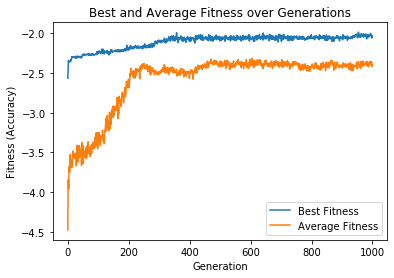

In [11]:
plt.plot(best_fitness, label = 'Best Fitness')
plt.plot(avg_fitness, label = 'Average Fitness')
plt.title('Best and Average Fitness over Generations')
plt.xlabel('Generation')
plt.ylabel('Fitness (Accuracy)')
plt.legend()
plt.show()

## Plot Sizes over Generations


In [12]:
sizes = np.genfromtxt('NEAT-results/sizes_fashion_mnist.csv', delimiter='')
avg_nodes = sizes[:,0]
avg_connections = sizes[:,1]

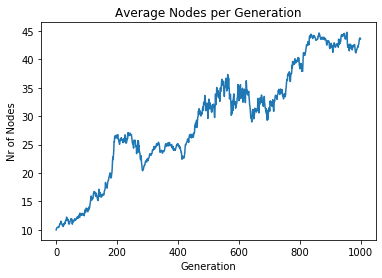

In [13]:
plt.plot(avg_nodes)
plt.title('Average Nodes per Generation')
plt.xlabel('Generation')
plt.ylabel('Nr of Nodes')
plt.show()

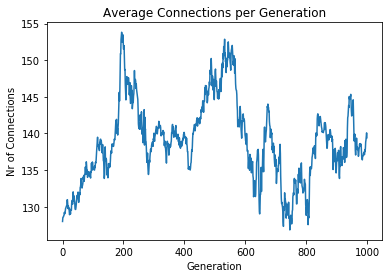

In [14]:
plt.plot(avg_connections)
plt.title('Average Connections per Generation')
plt.xlabel('Generation')
plt.ylabel('Nr of Connections')
plt.show()

## Load and Test Fittest Member

In [9]:
def test_fittest(config_file):
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)
    config.genome_config.add_activation('step', step)
    config.genome_config.add_activation('wcos', wann_cos)
    config.genome_config.add_activation('wsin', wann_sin)
    config.genome_config.add_activation('wsig', wann_sigmoid)
    config.genome_config.add_activation('winv', wann_inverse)
    config.genome_config.add_activation('wgauss', wann_gauss)
    preds_test = []
    preds_train = []
    train_correct = 0.
    test_correct = 0. 
    fittest_genome = pickle.load( open('NEAT-results/best_genomes_fashion', 'rb'))[0]
    #print(fittest_genome)
    net = neat.nn.FeedForwardNetwork.create(fittest_genome, config)
        
    for train, label in zip(X_train, Y_train):
        output = np.argmax(softmax(net.activate(train)))
        preds_train.append(output)
        if output == label:
            train_correct += 1.
    train_acc = train_correct / len(X_train)
    
    for test, label in zip(X_test, Y_test):
        output = np.argmax(softmax(net.activate(test)))
        preds_test.append(output)
        if output == label:
            test_correct += 1.
    test_acc = test_correct / len(X_test)
        
    print("Train Accuracy = {}".format(train_acc))
    print("Test Accuracy = {}".format(test_acc))
    
    return preds_train, preds_test

In [10]:
preds_train, preds_test = test_fittest(CONFIG_FILE)

Train Accuracy = 0.3552166666666667
Test Accuracy = 0.3545


In [11]:
cm_train = confusion_matrix(Y_train, preds_train, labels=range(N_CLASSES_TO_USE))
cm_test = confusion_matrix(Y_test, preds_test, labels=range(N_CLASSES_TO_USE))

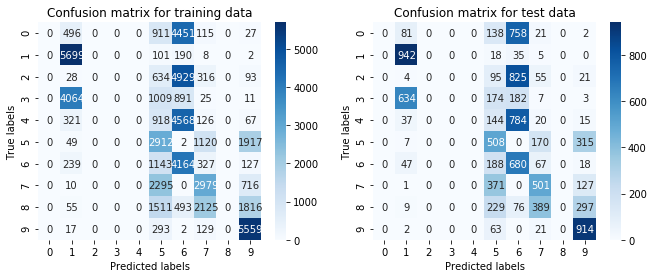

In [17]:
# Create figure
fig, ax = plt.subplots(1,2, figsize=(11,4))

# Plot confusion matrix for training data
sns.heatmap(cm_train, annot=True, fmt='g', ax=ax[0], cmap="Blues")
ax[0].set_xlabel('Predicted labels')
ax[0].set_ylabel('True labels')
ax[0].set_title('Confusion matrix for training data')

# Plot confusion matrix for validation data
sns.heatmap(cm_test, annot=True, fmt='g', ax=ax[1], cmap="Blues")
ax[1].set_xlabel('Predicted labels')
ax[1].set_ylabel('True labels')
ax[1].set_title('Confusion matrix for test data')

plt.savefig('confusion_neat_Fashion_MNIST.png')
# Show the result
plt.show()

## Inspecting Fittest Genome

In [18]:
fittest_genome = pickle.load( open('NEAT-results/best_genomes_fashion', 'rb'))[0]

In [19]:
print(fittest_genome)

Key: 236294
Fitness: -1.986236452723492
Nodes:
	0 DefaultNodeGene(key=0, bias=0.0, response=1.0, activation=winv, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=0.0, response=1.0, activation=wgauss, aggregation=sum)
	2 DefaultNodeGene(key=2, bias=0.0, response=1.0, activation=identity, aggregation=sum)
	3 DefaultNodeGene(key=3, bias=0.0, response=1.0, activation=abs, aggregation=sum)
	4 DefaultNodeGene(key=4, bias=0.0, response=1.0, activation=relu, aggregation=sum)
	5 DefaultNodeGene(key=5, bias=0.0, response=1.0, activation=wgauss, aggregation=sum)
	6 DefaultNodeGene(key=6, bias=0.0, response=1.0, activation=tanh, aggregation=sum)
	7 DefaultNodeGene(key=7, bias=0.0, response=1.0, activation=identity, aggregation=sum)
	8 DefaultNodeGene(key=8, bias=0.0, response=1.0, activation=wgauss, aggregation=sum)
	9 DefaultNodeGene(key=9, bias=0.0, response=1.0, activation=relu, aggregation=sum)
	5773 DefaultNodeGene(key=5773, bias=0.0, response=1.0, activation=step, aggregation=sum)
	29754 Def

In [20]:
used_input_pixels = []
for cg in fittest_genome.connections.values():
    if cg.enabled:
        used_input_pixels.append(cg.key[0])
print(used_input_pixels)

[-41, -51, -111, -12, -173, -225, -160, -110, -189, -121, -31, -165, -194, -23, -68, -251, 5773, -14, -55, -25, -146, -225, -11, -116, -208, -186, -123, -192, -152, 29754, 30367, -237, 33691, -224, 36460, -147, -49, -197, 32784, -146, -180, -173, 43195, -14, 43561, -144, -121, -146, 44603, -180, 44927, -186, -23, 46179, -59, 46320, -51, 46501, -226, 32784, 47486, -68, 47721, 47825, -14, -173, 48453, -155, -38, 48802, 30367, 48999, -165, -165, 50832, 32784, 50907, -103, 57493, -118, -191, -68, 57669, -227, 43043, 46501, -26]


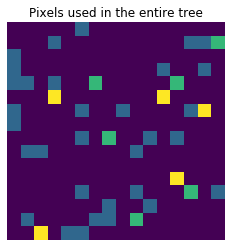

In [21]:
input_tallies = np.zeros(X_train.shape[1])
for arg in used_input_pixels:
    if arg < 0:
        input_tallies[arg] += 1
plt.imshow( input_tallies.reshape(16,16) )
plt.title('Pixels used in the entire tree')
plt.axis('off')
plt.savefig('inputs_neat_Fashion_MNIST.png')
plt.show()